## Double Deep Q-Learning for CartPole

This is a sample solution for the CartPole problem, defined by OpenAI here: https://gym.openai.com/envs/CartPole-v0/

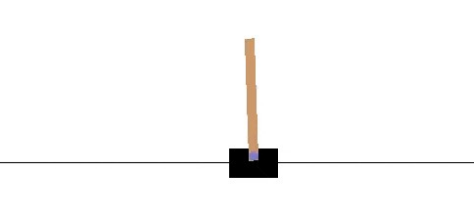

In [14]:
from IPython.display import display, Image  # allows to see images in GitLab
display(Image(filename='img/cart-pole-game.png', width=350))

#### Objective:

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

#### Rules:

- we are given following parameters for each timestep in the environment:
    - position of cart
    - velocity of cart
    - angle of pole
    - rotation rate of pole
- reward of +1 is provided for every timestep that the pole remains upright
- the episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center
- we have 2 actions: left 0 or right 0

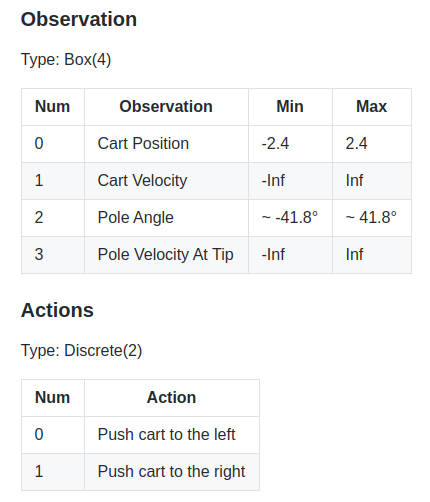

In [15]:
display(Image(filename='img/cart-pole-obs-actions.png', width=350))

#### Tutorial Goals:

- learn advanced Python and data processing/operations concepts, which can (*and should?*) be used in daily life at work
- learn what **Reinforcement Learning** is
- see how **Machine Learning** is used in temporal difference processes
- have *some fun* (!)

#### Disclaimer:

Don't worry if you don't understand something here. It is a complex challenge and you are encouraged to play around with the classes and functions and see what they do, put print statements, break it, see errors, fix it and do it your way.

Don't just blindly trust it, it can certainly be improved (*can you?*) !!

#### Key terminology

- Agent
- Replay Buffer and Experience
- Reward
- Terminal
- Policy

#### Python libraries used:

- random
- gym
- numpy
- keras
- matplotlib
- Jupyter Notebook

#### Recommended resources, which inspired this project:
- 2015 Mnih el al. paper: https://www.nature.com/articles/nature14236/
- 2018 BartoSutton RL book (v2): http://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf
- 2020 Medium article: https://medium.com/analytics-vidhya/building-a-powerful-dqn-in-tensorflow-2-0-explanation-tutorial-d48ea8f3177a
- 2019 *(\*Recommended)* In-depth study Notebook: https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
- 2019 YouTube tutorial: https://www.youtube.com/watch?v=a5XbO5Qgy5w&feature=youtu.be
- 2019 YouTube tutorial: https://www.youtube.com/watch?v=t3fbETsIBCY&list=PLQVvvaa0QuDezJFIOU5wDdfy4e9vdnx-7&index=5
- Wiki link to understand Bellman equation (1957): https://en.wikipedia.org/wiki/Bellman_equation

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### Configuration / parameters

In [2]:
ENV_NAME = 'CartPole-v0'
REPLAY_BUFFER_SIZE = 100000
TRAINING_BATCH_SIZE = 64
TRAINING_LEARNING_RATE = 0.0005
TARGET_UPDATE_FREQ = 250
TRAINING_FREQ = 1
EPSILON_START = 1.0
EPSILON_MIN = 0.08
EPSILON_DECAY = 0.998
EPSILON_DECAY_EVERY_N_EPISODES = 10
DISCOUNT_FACTOR = 0.99
N_EPISODES_CHECK_STATS = 10
N_EPISODES_SAVE_MODEL = 50
N_EPISODES = 500
N_STEPS = 250
DEBUG = False

#### Set up objects

In [5]:
# Import all classes and functions from Imports Notebook
%run CartPole-Imports.ipynb

# instance of gym environment wrapper
game_wrapper = GameWrapper(ENV_NAME, debug=False)

# set up memory buffer
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE, game_wrapper.n_actions,
                             game_wrapper.n_obsevations, debug=False)

# create 2 neural nets (policy and target)
policy_dqn = build_nn(game_wrapper.n_obsevations, game_wrapper.n_actions,
                      TRAINING_LEARNING_RATE, debug=False)
target_dqn = build_nn(game_wrapper.n_obsevations, game_wrapper.n_actions,
                      TRAINING_LEARNING_RATE, debug=False)

# set up agent
agent = Agent(replay_buffer, policy_dqn, target_dqn, game_wrapper.n_actions,
              TRAINING_BATCH_SIZE, game_wrapper.n_obsevations, EPSILON_START, EPSILON_MIN,
              EPSILON_DECAY, DISCOUNT_FACTOR, debug=False)

#### Run training loop

In [6]:
# initialise frame counter and a list to keep track of all rewards
frame_counter = 0
reward_history = []
eps_history = []

# wrap in try/except to catch Keyboard interrupts and gracefully close
# the environment (not doing this will annoy you, check it out! :D)
try:
    for episode in tqdm(range(N_EPISODES)):
        
        # reset environment
        game_wrapper.reset()
        total_reward = 0  # target is >= 195 for 100 consecutive trials
        
        for step in range(N_STEPS):
            
            # choose action using epsilon-greedy approach
            state = game_wrapper.state.copy()
            action = agent.choose_action(state)
            
            # take a step and collect variables
            reward, done = game_wrapper.step(action)
            new_state = game_wrapper.state.copy()
            total_reward += reward
            frame_counter += 1
            
            # add experience to the replay buffer
            agent.add_experience(action, state, reward, new_state, done)
            
            # check if training needs to happen, the recommendations for how often
            # to do the updates come from the 2015 Mnih el al. paper
            if frame_counter != 0 and frame_counter % TRAINING_FREQ == 0:
                agent.learn(frame_counter)
            
            # check if we need to refresh the Target Network
            if frame_counter != 0 and frame_counter % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()
                
            # check if we need to decrement epison (exploration rate)
            if frame_counter != 0 and frame_counter % EPSILON_DECAY_EVERY_N_EPISODES == 0:
                agent.dec_epsilon()
            
            # finish the episode if the game is over
            if done:
                break
        
        # collect stats for each episode
        reward_history.append(total_reward)
        eps_history.append(agent.eps_cur)
        
        if episode % N_EPISODES_CHECK_STATS == 0:
            # print average reward from last N-episodes
            avg_score = np.mean(reward_history[max(0, episode-100):(episode+1)])
            cur_eps = agent.eps_cur
            print('Episode', episode, 'cur score %.2f' % total_reward,
                  'avg score %.2f' % avg_score, 'cur eps %.2f' % cur_eps)
        
        # print stats every N-episodes and save model's snapshot
        if episode != 0 and episode % N_EPISODES_SAVE_MODEL == 0:
            agent.save_model('policy_dqn.h5')

except KeyboardInterrupt:
    pass
except Exception as e:
    game_wrapper.close()
    raise e
game_wrapper.close()

Episode 0 cur score 31.00 avg score 31.00 cur eps 0.99
Episode 10 cur score 10.00 avg score 16.64 cur eps 0.96
Episode 20 cur score 18.00 avg score 16.81 cur eps 0.93
Episode 30 cur score 26.00 avg score 19.71 cur eps 0.89
Episode 40 cur score 61.00 avg score 23.59 cur eps 0.83
Episode 50 cur score 18.00 avg score 23.75 cur eps 0.78
Episode 60 cur score 38.00 avg score 25.33 cur eps 0.73
Episode 70 cur score 32.00 avg score 24.97 cur eps 0.70
Episode 80 cur score 26.00 avg score 26.81 cur eps 0.65
Episode 90 cur score 39.00 avg score 28.91 cur eps 0.59
Episode 100 cur score 97.00 avg score 34.09 cur eps 0.50
Episode 110 cur score 29.00 avg score 35.14 cur eps 0.47
Episode 120 cur score 121.00 avg score 41.41 cur eps 0.41
Episode 130 cur score 116.00 avg score 45.93 cur eps 0.35
Episode 140 cur score 81.00 avg score 50.66 cur eps 0.30
Episode 150 cur score 13.00 avg score 55.79 cur eps 0.26
Episode 160 cur score 174.00 avg score 64.20 cur eps 0.20
Episode 170 cur score 130.00 avg score 

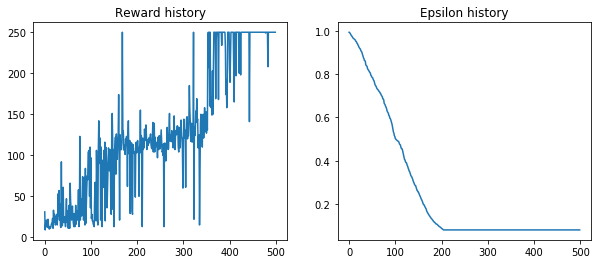

In [8]:
# Plot rewards and epsilons across all played episodes
x = [i for i in range(len(reward_history))]
f, ax = plt.subplots(1, 2)
f.set_figheight(4); f.set_figwidth(10)
ax[0].plot(x, reward_history)
ax[0].set_title('Reward history')
ax[1].plot(x, eps_history)
ax[1].set_title('Epsilon history')
plt.show()